In [ ]:
# default_exp nnsig

### Neural network using numpy
#### works on cpu only if there's no pyopencl and else

In [ ]:
#export
import numpy as np

#### fetch dataset

In [ ]:
#export
def fetch(url):
    import requests, hashlib, os, tempfile
    fp = os.path.join(tempfile.gettempdir(), hashlib.md5(url.encode('utf-8')).hexdigest())

    if os.path.isfile(fp):
        with open(fp, "rb") as f:
            dat = f.read()
    
    else:
        dat = requests.get(url).content
        with open(fp + ".tmp", "wb") as f:
            f.write(dat)
        
        os.rename(fp+".tmp", fp)
    
    return dat

In [ ]:
#export
def mnist(url1="http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz", url2="http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz", url3="http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz", url4="http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz"):
    # from geohot
    import gzip
    import numpy as np

    def parse(dat): return np.frombuffer(
        gzip.decompress(dat), dtype=np.uint8).copy()

    X_train = parse(fetch(url1))[0x10:].reshape((-1, 28, 28))
    Y_train = parse(fetch(url2))[8:]
    X_test = parse(fetch(url3))[0x10:].reshape((-1, 28, 28))
    Y_test = parse(fetch(url4))[8:]
    return X_train, Y_train, X_test, Y_test


#### import mnist dataset

In [ ]:
x_train,y_train,x_test,y_test = mnist()
x_train.shape

(60000, 28, 28)

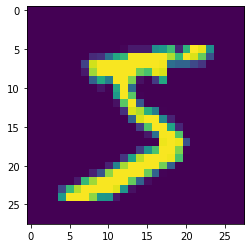

In [ ]:
from matplotlib import pyplot as plt

plt.imshow(x_train[0])
plt.show()

### Should set type to float32 / 16 ?

#### utils function

In [ ]:
#export 
# inits
def kaiming_uniform(h,w):
    return np.random.uniform(-1.,1.,size=(h,w))/np.sqrt(h*w)

# ref to pytorch to see how gain is calculated
# not tested
def kaiming_normal(h,w,gain=1):
    return np.random.randn(h,w)/np.sqrt(2./h)*gain

In [ ]:
x = np.array([[1,2],[3,4]])
x.mean(axis=0), x.mean(axis=1)

(array([2., 3.]), array([1.5, 3.5]))

In [ ]:
# export 
def stat(x):
    """ get standard deviation and mean of matrix x"""
    avg = x.mean()
    std = np.square(x - avg).mean()
    return avg, std

In [ ]:
stat(x)

(2.5, 1.25)

In [ ]:
x[None], x

(array([[[1, 2],
         [3, 4]]]),
 array([[1, 2],
        [3, 4]]))

In [ ]:
# see if std of init weight = 1 ?


## Try to add __ repr __ and dict 
#### To store the layers and therefore more customizable, also, enable to save the weights much more convenient
#### 

### Build the layers

In [ ]:
# export
class Linear:
    def __init__(self,h,w,init_fn = kaiming_uniform):
        self.weight = init_fn(h,w)
        self.grad = np.zeros((h,w))
        self.fpass = None
    
    def forward(self,x):
        out = x @ self.weight
        self.fpass = x
        return out
    
    def backward(self,bpass):
        self.grad = (self.fpass.T) @ bpass
        # without returning it, it doesn't work
        # bpass = bpass @ (self.weight.T)

In [ ]:
one = Linear(784,128)
one.weight[0,:5], one.weight.shape, one.forward(x_train[0:1].reshape(1,-1)).shape

(array([ 6.28049190e-05, -1.23367011e-04, -2.62161862e-03, -3.14008724e-03,
         2.73720522e-03]),
 (784, 128),
 (1, 128))

In [ ]:
one.fpass.shape, one.grad.shape

((1, 784), (784, 128))

#### Loss functions

In [ ]:
# export 
def MSELoss(yhat,y,num_class=10,supervised=True):
    if supervised:
        label = np.zeros((len(y), num_class), dtype=np.float32)
        label[range(label.shape[0]), y] = 1
        y = label
    val = np.square(yhat - y).mean(axis=0)
    grad = 2 * (yhat - y) / len(yhat)
    return val, grad

# can be achieved via NNL_Loss and softmax
def NNL():
    """ negative log likelihood """
    return

def CELoss(yhat,y):
    """ cross entropy loss"""
    return

In [ ]:
a = np.array([[1,2],[3,4]])
a.mean(axis=0), a.mean(axis=1), a.mean(axis=-1)

(array([2., 3.]), array([1.5, 3.5]), array([1.5, 3.5]))

### Optimizer 

In [ ]:
# export
def SGD(lr = 1e-3, model = None):
    for layer in model:
        layer.weight -= lr * layer.grad

def Adam():
    pass

### Build Sequential model class ?

In [ ]:
# export
class Sequential:
    # learn **kwargs
    def __init__(self,layers,lossfn,opt_fn):
        if not isinstance(layers,list):
            self.model = [layers]
        else:
            self.model = layers
        
        self.lossfn = lossfn
        self.opt_fn = opt_fn
    
    # check arguments when it comes to validation
    def forward(self,x):
        out = self.model[0].forward(x)
        for layer in self.model[1:]:
            out = layer.forward(out)
        return out

    def backward(self,grad):
        for layer in reversed(self.model):
            layer.backward(grad)
            grad = grad @ (layer.weight.T)

    def fit(self,x,y,epoch=1,batch_size=64,x_test=None,y_test=None):
        # loop thru len//bs
        losses = []
        ln = len(x)
        for _ in range(ln//batch_size):
            losses += self.fit_one_batch(x,y,epoch,batch_size,x_test,y_test)
        return losses

    def fit_one_batch(self,x,y,epoch=1,batch_size=64,x_test=None,y_test=None):
        # loop thru len//bs
        losses = []
        ln = len(x)
        for _ in range(epoch):
            idx = np.random.randint(0,ln,size=batch_size)
            x_ = x[idx].reshape((-1,28*28))
            y_ = y[idx]
            out = self.forward(x_)

            loss, grad = self.lossfn(out,y_)
            self.backward(grad)
            self.opt_fn(lr=1e-5, model=self.model)

            losses.append(loss.mean())
        
        return losses        


In [ ]:
# train for a epoch here
model = Sequential([Linear(784,128),Linear(128,10)],MSELoss,SGD)

In [ ]:
losses = model.fit(x_train,y_train,epoch=2)

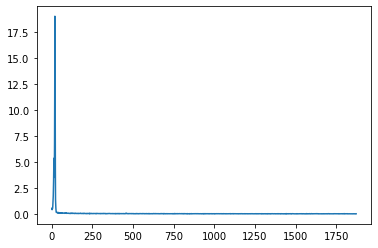

0.04690554062298615

In [ ]:
from matplotlib import pyplot as plt
plt.plot(list(range(len(losses))),losses)
plt.show()
losses[-1]

In [ ]:
""" It's correct now """
for i in range(10):
    print(np.argmax(model.forward(x_test[i:i+1].reshape((-1,28*28)))), y_test[i])

7 7
2 2
1 1
0 0
4 4
1 1
4 4
9 9
5 5
9 9


### Conv Layer

#### Check docs to see if there's is a different way to calculated gradient

In [ ]:
# export
# not tested
class Conv:
    def __init__(self,filters,kernelsize,padding=0,init_fn=kaiming_uniform):
        self.weight = np.zeros((filters,kernelsize,kernelsize))
        for f in self.weight:
            f = init_fn(kernelsize,kernelsize)
        self.grad = np.zeros((filters,kernelsize,kernelsize))
        self.fpass = None

    def forward(self,x):
        # take advantage of einsum for speed and simplicity
        # assume x.shape[0] == x.shape[1]
        # ...
        return

    def backward(self,grad):
        # transpose weight to calculate gradient ?
        return 

In [ ]:
# naive function of convolution
def naive(f,x,st=2,ks=3):
    out = np.zeros((((x.shape[0]-ks)//st+1),((x.shape[1]-ks)//st+1)))
    for i in range(0,x.shape[0]-1,st):
        for j in range(0,x.shape[1]-1,st):
            # for debug
            # print(i,":",i+ks,"->",j,":",j+ks)
            # print(x[i:i+ks,j:j+ks])
            out[i//st,j//st] = np.multiply(f,x[i:i+ks,j:j+ks]).sum()
    
    return out


In [ ]:
naive(f,np.arange(49).reshape(7,7))


array([[ 420.,  492.,  564.],
       [ 924.,  996., 1068.],
       [1428., 1500., 1572.]])

### Flatten / unsqueeze

#### I don't think this is the right way to do, since it requires way too much conditioning in the model class

In [ ]:
# export
# not tested: 90% certain it's correct
# we're only use library (numpy) 
# since it's slow to do computation in pure python
class Flatten:
    """
    reshape input to target shape
    """
    def __init__(self):
        self.shape=None

    def forward(self,x):
        self.shape = x.shape
        return x.reshape((1,-1))
    
    def backward(self,grad):
        return grad.reshape(self.shape)

In [ ]:
x = np.array([[1,2],[3,4]])
l = Flatten()
x, l.forward(x), l.backward(l.forward(x))

(array([[1, 2],
        [3, 4]]),
 array([[1, 2, 3, 4]]),
 array([[1, 2],
        [3, 4]]))

### Build CNN here (regular one and pure Conv one)

In [ ]:
cnn_reg = Sequential([Conv(), Conv(), Flatten(), Linear(), Linear()])



In [ ]:
cnn_p = Sequential([Conv(), Conv(), Linear()])


### Experiment below

In [ ]:
# Tensor class to inherit from
# implement context tensor ??
class Tensor:
    def __init__(self):
        self.grad = None
    
    def unsqueeze():
        pass

#### Rebuild everything from a lower level
#### e.g. a tensor for layers to inherit from that handles backprop

### Export

In [ ]:
from nbdev.export import notebook2script
notebook2script()

Converted 00_core.ipynb.
Converted 01_oval_clean.ipynb.
Converted 02_NN.ipynb.
Converted 03_NN_numpy.ipynb.
Converted index.ipynb.
